In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Normalize data with testing data
##### use default normalizing condition which is mean, std of mnist training dataset which we use as testing data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])


## Use Mnist train as test and vice versa

In [5]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)


In [6]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())


the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


## Optimization
#### use any stochastic gradient descent algorithm for the optimization
#### use any size of the mini-batch
#### use any optimization algorithm (for example, Momentum, AdaGrad, RMSProp, Adam)
#### use any regularization algorithm (for example, Dropout, Weight Decay)
#### use any annealing scheme for the learning rate (for example, constant, decay, staircase)

## Desigining Model
##### design a neural network architecture with three layers (input layer, one hidden layer and output layer)
##### the input dimension of the input layer should be 784 (28 * 28)
##### the output dimension of the output layer should be 10 (class of digits)
##### all the layers should be fully connected layers

##### use any type of activation functions

In [71]:
layer_2 = 14*14
layer_3 = 7*7

class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=layer_2),
            nn.Softmax(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=layer_2, out_features=layer_3),
            nn.Softmax(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=layer_3, out_features=10),
        ) 
        
        
    def forward(self, inputs):                 
        x = inputs.view(inputs.size(0), -1)    
        
        x = self.classifier1(x)               
        x = F.dropout(x, p = 0.3, training=self.training) # use dropout when training
        
        x = self.classifier2(x)
        x = F.dropout(x, p = 0.3, training=self.training)
       
        out = self.classifier3(x)              
        
        return out


# Define a function that can change optimizer


In [93]:
import time

def startTraining(batch_size,epoch,learning_rate_value, optimizer_string, weight_decay, momentum=0.9):
    #start training 
    start_time = time.time()
    print("start training for", optimizer_string)
    device = "cuda"
    
    classifier = classification().to("cuda")
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value, weight_decay= weight_decay)
    if optimizer_string == "Adam":
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay)
    if optimizer_string == "RMSprop":
        optimizer = torch.optim.RMSprop(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay, momentum = momentum)
    if optimizer_string == "Adagrad":
        optimizer = torch.optim.Adagrad(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay)
    criterion = nn.CrossEntropyLoss();
    #define array to save values
    
    loss_train_arr=np.zeros(epoch)
    accuracy_train_arr=np.zeros(epoch)
    loss_test_arr=np.zeros(epoch)
    accuracy_test_arr=np.zeros(epoch)

    batched_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    batched_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=True)
    
    best_accuracy = 0.9
    best_epoch = 0;
    
    for i in range(epoch):
        
        loss_train=0
        accuracy_train=0
        loss_test=0
        accuracy_test=0
        
        
        classifier.train()
        #train and compute loss, accuracy
        for img, label in batched_train:
            img=img.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            predicted = classifier(img)

            label_predicted = torch.argmax(predicted,dim=1)
            loss = criterion(predicted, label)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            accuracy_train += torch.sum(label_predicted==label)


        loss_train_arr[i]=loss_train/(len(batched_train)) 
        accuracy_train_arr[i]=accuracy_train/len(batched_train.dataset)
        
        classifier.eval()
        #test, no need to backward, step
        for img, label in batched_test:
            img=img.to(device)
            label=label.to(device)
            
            with torch.autograd.no_grad():
                predicted = classifier(img)
                label_predicted = torch.argmax(predicted,dim=1)
                loss = criterion(predicted, label)

                loss_test += loss.item()
                accuracy_test += torch.sum(label_predicted==label)

        loss_test_arr[i]=loss_test/(len(batched_test))
        accuracy_test_arr[i]=accuracy_test/len(batched_test.dataset)
        
        if accuracy_test_arr[i] > best_accuracy:
            best_accuracy = accuracy_test_arr[i]
            best_epoch = i
            print("epoch ", i, "reached best accuracy ", best_accuracy, '%');
        

        if i%10==0:
            print("epoch ",i)
            print("train loss", loss_train_arr[i],"train accuracy: ",accuracy_train_arr[i])
            print("test loss", loss_test_arr[i],"test accuracy", accuracy_test_arr[i])
    print("execution time =======", time.time()-start_time)
    
    
    return loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch


## Loss function - cross entropy

In [9]:
criterion = nn.CrossEntropyLoss()

## Start Training for different optimizer

In [10]:
batch_size = 32
epoch = 100
learning_rate_value = 0.1
weight_decay = 0

In [13]:
loss_train_adam, loss_test_adam, acc_train_adam, acc_test_adam, best_adam = startTraining(batch_size,epoch,learning_rate_value, "SGD", weight_decay)

start training for SGD
epoch  0
train loss 0.5227972334042524 train accuracy:  0.8413999676704407
test loss 0.30220477665861445 test accuracy 0.9067167043685913
epoch  10
train loss 0.009959486652100656 train accuracy:  0.9970999956130981
test loss 0.1755015723010525 test accuracy 0.9583333730697632
epoch  20
train loss 0.0019809445536655623 train accuracy:  0.9996999502182007
test loss 0.18935096180269176 test accuracy 0.9604166746139526
epoch  30
train loss 0.0020618596408400543 train accuracy:  0.9993000030517578
test loss 0.20301395132653804 test accuracy 0.9599166512489319
epoch  40
train loss 0.0009355999288328194 train accuracy:  0.9998999834060669
test loss 0.2134935742846068 test accuracy 0.9600000381469727
epoch  50
train loss 0.0006790940577239656 train accuracy:  0.9998999834060669
test loss 0.21817123196443694 test accuracy 0.9594166874885559
epoch  60
train loss 0.0005891109099589091 train accuracy:  0.9997999668121338
test loss 0.2189617635138533 test accuracy 0.96001666

[]

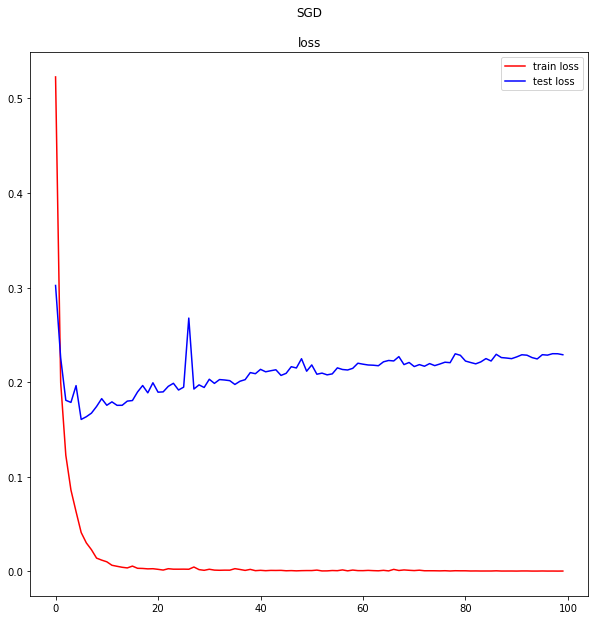

In [16]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_adam,label="train loss",c="red")
plt.plot(loss_test_adam,label="test loss",c="blue")
plt.title("SGD\n\nloss")
plt.legend()
plt.plot()

[]

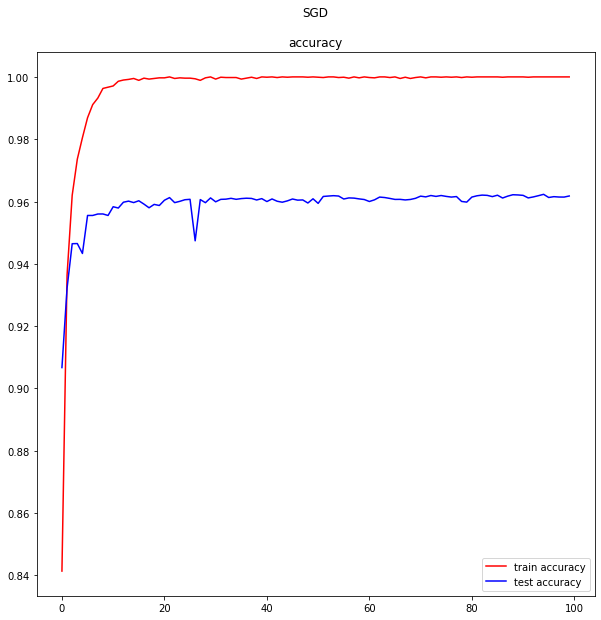

In [17]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_adam,label="train accuracy",c="red")
plt.plot(acc_test_adam,label="test accuracy",c="blue")
plt.title("SGD\n\naccuracy")
plt.legend()
plt.plot()

In [32]:
batch_size = 32
epoch = 100
learning_rate_value = 0.5
weight_decay = 0

In [33]:
loss_train_rms, loss_test_rms, acc_train_rms, acc_test_rms, best_rms = startTraining(batch_size,epoch,learning_rate_value, "RMSprop", weight_decay)

start training for RMSprop
epoch  0
train loss 92376156.1056458 train accuracy:  0.6783999800682068
test loss 9443275.5822 test accuracy 0.8043500185012817
epoch  10
train loss 21861007.067092653 train accuracy:  0.877299964427948
test loss 30699984.658383332 test accuracy 0.8632833361625671
epoch  20
train loss 31450354.51158147 train accuracy:  0.9096999764442444
test loss 114901798.65901667 test accuracy 0.8978166580200195
epoch  30
train loss 35556306.5399361 train accuracy:  0.9340999722480774
test loss 185265126.16 test accuracy 0.8977333307266235
epoch  40
train loss 54617730.86261981 train accuracy:  0.9418999552726746
test loss 277151490.82133335 test accuracy 0.9208833575248718
epoch  50
train loss 51898104.96485623 train accuracy:  0.9578999876976013
test loss 414200889.6192 test accuracy 0.9238666892051697
epoch  60
train loss 60735414.03194888 train accuracy:  0.9634999632835388
test loss 710692075.0997334 test accuracy 0.9270166754722595
epoch  70
train loss 70623930.7859

[]

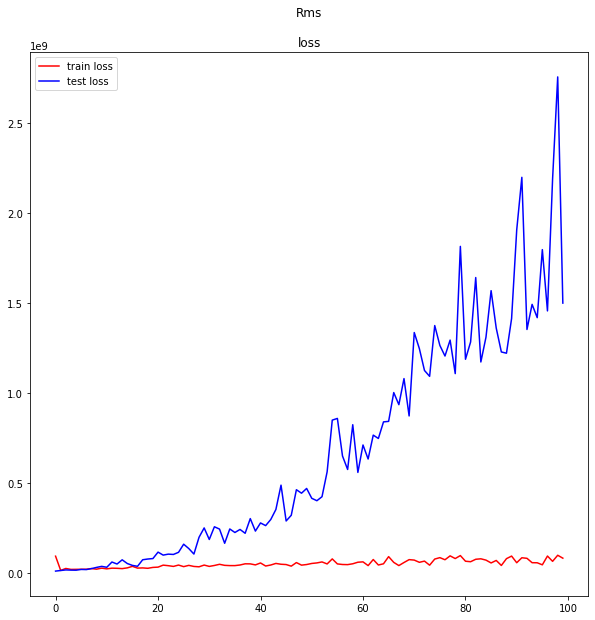

In [34]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_rms,label="train loss",c="red")
plt.plot(loss_test_rms,label="test loss",c="blue")
plt.title("Rms\n\nloss")
plt.legend()
plt.plot()

[]

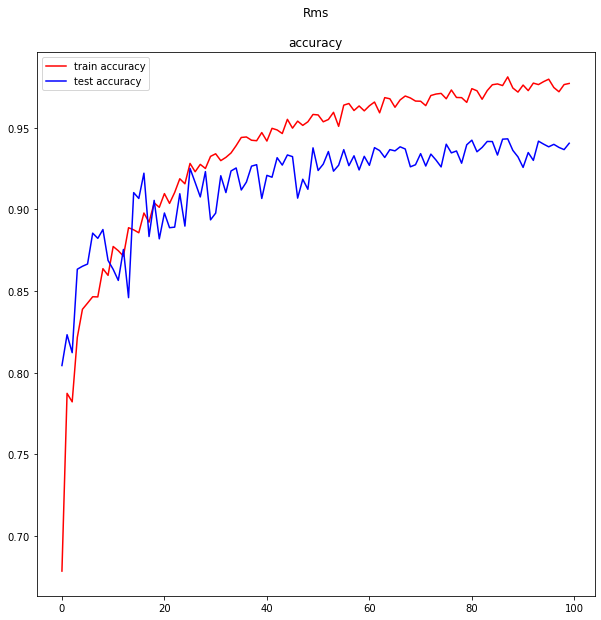

In [38]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_rms,label="train accuracy",c="red")
plt.plot(acc_test_rms,label="test accuracy",c="blue")
plt.title("Rms\n\naccuracy")
plt.legend()
plt.plot()

In [36]:
print(acc_test_rms[best_rms])

0.8043500185012817


## Overfits => decrease number of neuron in layer, increase dropout rate

In [158]:
layer_2 = 14*14
layer_3 = 10*10

class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=layer_2),
            nn.ReLU(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=layer_2, out_features=layer_3),
            nn.ReLU(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=layer_3, out_features=10),
        ) 
        
        
    def forward(self, inputs):                 
        x = inputs.view(inputs.size(0), -1)    
        
        x = self.classifier1(x)               
        x = F.dropout(x, p = 0.3, training=self.training) # use dropout when training
        
        x = self.classifier2(x)
        x = F.dropout(x, p = 0.2, training=self.training)
       
        out = self.classifier3(x)              
        
        return out


In [159]:
batch_size = 128
epoch = 50
learning_rate_value = 0.5
weight_decay = 0

In [156]:
loss_train_sgd, loss_test_sgd, acc_train_sgd, acc_test_sgd, best_sgd = startTraining(batch_size,epoch,learning_rate_value, "Adagrad", weight_decay)

print(best_sgd)

start training for Adagrad
epoch  0
train loss 2071.464148255843 train accuracy:  0.3928999900817871
test loss 10.927023573724954 test accuracy 0.4161333441734314


KeyboardInterrupt: 

In [ ]:
best_sgd

In [ ]:
from torch.optim.lr_scheduler import StepLR

def startTraining2(batch_size,epoch,learning_rate_value, optimizer_string, learning_rate_decay):
    #start training 
    start_time = time.time()
    print("start training for", optimizer_string)
    device = "cuda"
    
    
    classifier = classification().to("cuda")
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adam":
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "RMSprop":
        optimizer = torch.optim.RMSprop(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adagrad":
        optimizer = torch.optim.Adagrad(classifier.parameters(), lr=learning_rate_value)
    criterion = nn.CrossEntropyLoss();
    #define array to save values
    
    scheduler = StepLR(optimizer, step_size=10, gamma = learning_rate_decay)
    
    
    loss_train_arr=np.zeros(epoch)
    accuracy_train_arr=np.zeros(epoch)
    loss_test_arr=np.zeros(epoch)
    accuracy_test_arr=np.zeros(epoch)

    batched_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    batched_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=True)
    
    best_accuracy = 0.9
    best_epoch = 0;
    
    for i in range(epoch):
        loss_train=0
        accuracy_train=0
        loss_test=0
        accuracy_test=0
        
        classifier.train()
        #train and compute loss, accuracy
        for img, label in batched_train:
            img=img.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            predicted = classifier(img)

            label_predicted = torch.argmax(predicted,dim=1)
            loss = criterion(predicted, label)
            loss.backward()
            optimizer.step()
            

            loss_train += loss.item()
            accuracy_train += torch.sum(label_predicted==label)
        scheduler.step()

        loss_train_arr[i]=loss_train/(len(batched_train)) 
        accuracy_train_arr[i]=accuracy_train/len(batched_train.dataset)
        
        classifier.eval()
        #test, no need to backward, step
        for img, label in batched_test:
            img=img.to(device)
            label=label.to(device)
            
            with torch.autograd.no_grad():
                predicted = classifier(img)
                label_predicted = torch.argmax(predicted,dim=1)
                loss = criterion(predicted, label)

                loss_test += loss.item()
                accuracy_test += torch.sum(label_predicted==label)

        loss_test_arr[i]=loss_test/(len(batched_test))
        accuracy_test_arr[i]=accuracy_test/len(batched_test.dataset)
        
        if accuracy_test_arr[i] > best_accuracy:
            best_accuracy = accuracy_test_arr[i]
            best_epoch = i
            print("epoch ", i, "reached best accuracy ", best_accuracy, '%');
        

        if i%10==0:
            print("epoch ",i)
            print("train loss", loss_train_arr[i],"train accuracy: ",accuracy_train_arr[i])
            print("test loss", loss_test_arr[i],"test accuracy", accuracy_test_arr[i])
            
    print("execution time =======", time.time()-start_time)
    
    
    return loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch


In [160]:
batch_size = 128
epoch = 50
learning_rate_value = 0.2
lr_decay = 0.6

In [ ]:
loss_train_rms, loss_test_rms, acc_train_rms, acc_test_rms, best_rms = startTraining2(batch_size,epoch,learning_rate_value, "RMSProp",lr_decay)

print(best_rms)

In [162]:
loss_train_sgd, loss_test_sgd, acc_train_sgd, acc_test_sgd, best_sgd = startTraining2(batch_size,epoch,learning_rate_value, "Sgd", lr_decay)

print(acc_test_sgd[best_sgd])

start training for Sgd
epoch  0
train loss 0.8510473887377148 train accuracy:  0.7264999747276306
test loss 1.2342639541320963 test accuracy 0.6437833309173584
epoch  2 reached best accuracy  0.9074333310127258 %
epoch  3 reached best accuracy  0.9287000298500061 %
epoch  5 reached best accuracy  0.9396166801452637 %
epoch  7 reached best accuracy  0.9454333186149597 %
epoch  9 reached best accuracy  0.9524833559989929 %
epoch  10 reached best accuracy  0.9534833431243896 %
epoch  10
train loss 0.06384112799092184 train accuracy:  0.9805999994277954
test loss 0.16636217145650373 test accuracy 0.9534833431243896
epoch  13 reached best accuracy  0.9550166726112366 %
epoch  14 reached best accuracy  0.9554499983787537 %
epoch  18 reached best accuracy  0.9569500088691711 %
epoch  20 reached best accuracy  0.9571999907493591 %
epoch  20
train loss 0.03672759025062941 train accuracy:  0.9899999499320984
test loss 0.16474004056471497 test accuracy 0.9571999907493591
epoch  22 reached best ac

In [163]:
layer_2 = 20*20
layer_3 = 14*14

class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=layer_2),
            nn.ReLU(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=layer_2, out_features=layer_3),
            nn.ReLU(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=layer_3, out_features=10),
        ) 
        
        
    def forward(self, inputs):                 
        x = inputs.view(inputs.size(0), -1)    
        
        x = self.classifier1(x)               
        x = F.dropout(x, p = 0.5, training=self.training) # use dropout when training
        
        x = self.classifier2(x)
        x = F.dropout(x, p = 0.4, training=self.training)
       
        out = self.classifier3(x)              
        
        return out


In [167]:
batch_size = 32
epoch = 50
learning_rate_value = 0.1
lr_decay=0.7

In [168]:
from torch.optim.lr_scheduler import StepLR

def startTraining3(batch_size,epoch,learning_rate_value, optimizer_string, learning_rate_decay):
    #start training 
    start_time = time.time()
    print("start training for", optimizer_string)
    device = "cuda"
    
    
    classifier = classification().to("cuda")
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adam":
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "RMSprop":
        optimizer = torch.optim.RMSprop(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adagrad":
        optimizer = torch.optim.Adagrad(classifier.parameters(), lr=learning_rate_value)
    criterion = nn.CrossEntropyLoss();
    #define array to save values
    
    scheduler = StepLR(optimizer, step_size=10, gamma = learning_rate_decay)
    
    
    loss_train_arr=np.zeros(epoch)
    accuracy_train_arr=np.zeros(epoch)
    loss_test_arr=np.zeros(epoch)
    accuracy_test_arr=np.zeros(epoch)

    batched_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    batched_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=True)
    
    best_accuracy = 0.9
    best_epoch = 0;
    
    for i in range(epoch):
        loss_train=0
        accuracy_train=0
        loss_test=0
        accuracy_test=0
        
        classifier.train()
        #train and compute loss, accuracy
        for img, label in batched_train:
            img=img.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            predicted = classifier(img)

            label_predicted = torch.argmax(predicted,dim=1)
            loss = criterion(predicted, label)
            loss.backward()
            optimizer.step()
            

            loss_train += loss.item()
            accuracy_train += torch.sum(label_predicted==label)
        scheduler.step()

        loss_train_arr[i]=loss_train/(len(batched_train)) 
        accuracy_train_arr[i]=accuracy_train/len(batched_train.dataset)
        
        classifier.eval()
        #test, no need to backward, step
        for img, label in batched_test:
            img=img.to(device)
            label=label.to(device)
            
            with torch.autograd.no_grad():
                predicted = classifier(img)
                label_predicted = torch.argmax(predicted,dim=1)
                loss = criterion(predicted, label)

                loss_test += loss.item()
                accuracy_test += torch.sum(label_predicted==label)

        loss_test_arr[i]=loss_test/(len(batched_test))
        accuracy_test_arr[i]=accuracy_test/len(batched_test.dataset)
        
        if accuracy_test_arr[i] > best_accuracy:
            best_accuracy = accuracy_test_arr[i]
            best_epoch = i
            print("epoch ", i, "reached best accuracy ", best_accuracy, '%');
        

        if i%10==0:
            print("epoch ",i)
            print("train loss", loss_train_arr[i],"train accuracy: ",accuracy_train_arr[i])
            print("test loss", loss_test_arr[i],"test accuracy", accuracy_test_arr[i])
            
    print("execution time =======", time.time()-start_time)
    
    
    return loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch


In [169]:
loss_train_sgd2, loss_test_sgd2, acc_train_sgd2, acc_test_sgd2, best_sgd2 = startTraining3(batch_size,epoch,learning_rate_value, "Sgd", lr_decay)

print(acc_test_sgd2[best_sgd2])

start training for Sgd
epoch  0 reached best accuracy  0.9048166871070862 %
epoch  0
train loss 0.6557418271994438 train accuracy:  0.789900004863739
test loss 0.3230255912860235 test accuracy 0.9048166871070862
epoch  1 reached best accuracy  0.9291166663169861 %
epoch  2 reached best accuracy  0.940583348274231 %
epoch  5 reached best accuracy  0.9433667063713074 %
epoch  6 reached best accuracy  0.95496666431427 %
epoch  8 reached best accuracy  0.9560166597366333 %
epoch  9 reached best accuracy  0.9569166898727417 %
epoch  10
train loss 0.07209494718523048 train accuracy:  0.9768999814987183
test loss 0.1716605974928631 test accuracy 0.9566166996955872
epoch  12 reached best accuracy  0.9586333632469177 %
epoch  13 reached best accuracy  0.9602167010307312 %
epoch  15 reached best accuracy  0.9606833457946777 %
epoch  19 reached best accuracy  0.9608833193778992 %
epoch  20 reached best accuracy  0.9623000025749207 %
epoch  20
train loss 0.02987210369522359 train accuracy:  0.9905

# Outputs

# 1. Plot the training and testing losses over epochs [2pt]

[]

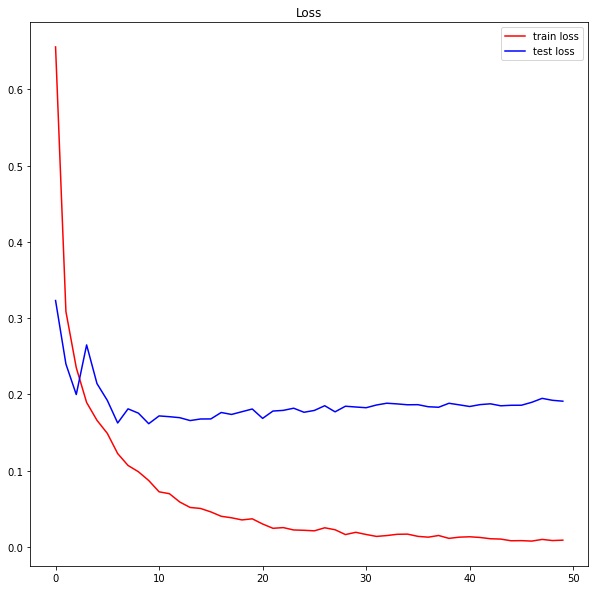

In [173]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_sgd2,label="train loss",c="red")
plt.plot(loss_test_sgd2,label="test loss",c="blue")
plt.title("Loss")
plt.legend()
plt.plot()

# 2. Plot the training and testing accuracies over epochs [2pt]

[]

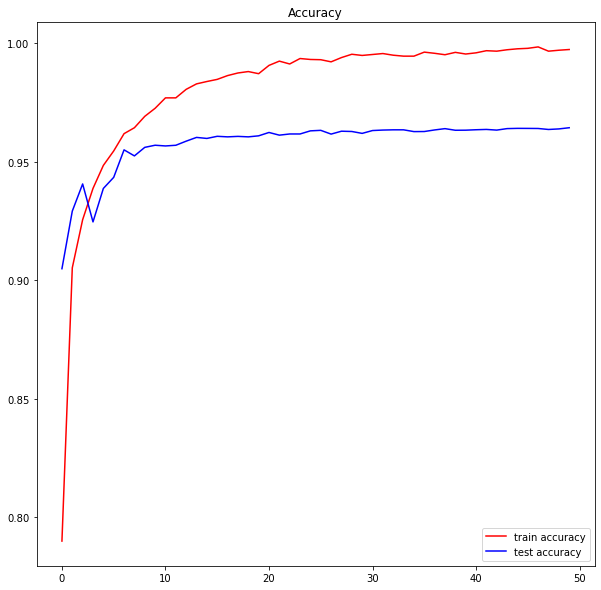

In [175]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_sgd2,label="train accuracy",c="red")
plt.plot(acc_test_sgd2,label="test accuracy",c="blue")
plt.title("Accuracy")
plt.legend(loc=4)
plt.plot()

# 3. Print the final training and testing losses at convergence [2pt]

In [171]:
print("training loss  ",loss_train_sgd2[49])
print("testing loss   ",loss_test_sgd2[49])

training loss   0.008669205423893945
testing loss    0.1909789605850897


In [176]:
print("training accuracy  ",acc_train_sgd2[49])
print("testing accuracy   ",acc_test_sgd2[49])

training accuracy   0.9972999691963196
testing accuracy    0.9643000364303589
